In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [2]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [3]:
print(df_train.info())
df_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
208,209,1,3,"Carr, Miss. Helen ""Ellen""",female,16.0,0,0,367231,7.75,NaN,Q
337,338,1,1,"Burns, Miss. Elizabeth Margaret",female,41.0,0,0,16966,134.50,E40,C
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S


In [4]:
print(df_test.info())
df_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
300,1192,3,"Olsson, Mr. Oscar Wilhelm",male,32.0,0,0,347079,7.775,NaN,S
70,962,3,"Mulvihill, Miss. Bertha E",female,24.0,0,0,382653,7.750,NaN,Q
13,905,2,"Howard, Mr. Benjamin",male,63.0,1,0,24065,26.000,NaN,S


In [5]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




In [6]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
0,Age,Age,1.000000
9,Age,Pclass,0.408106
18,Age,SibSp,0.243699
21,Age,Fare,0.178740
26,Age,Parch,0.150917
30,Age,Survived,0.077221
41,Age,PassengerId,0.028814


In [7]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

# Filling the missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


In [8]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [9]:
# Filling the missing values in Embarked with S
df_all['Embarked'] = df_all['Embarked'].fillna('S')

In [10]:
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [11]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

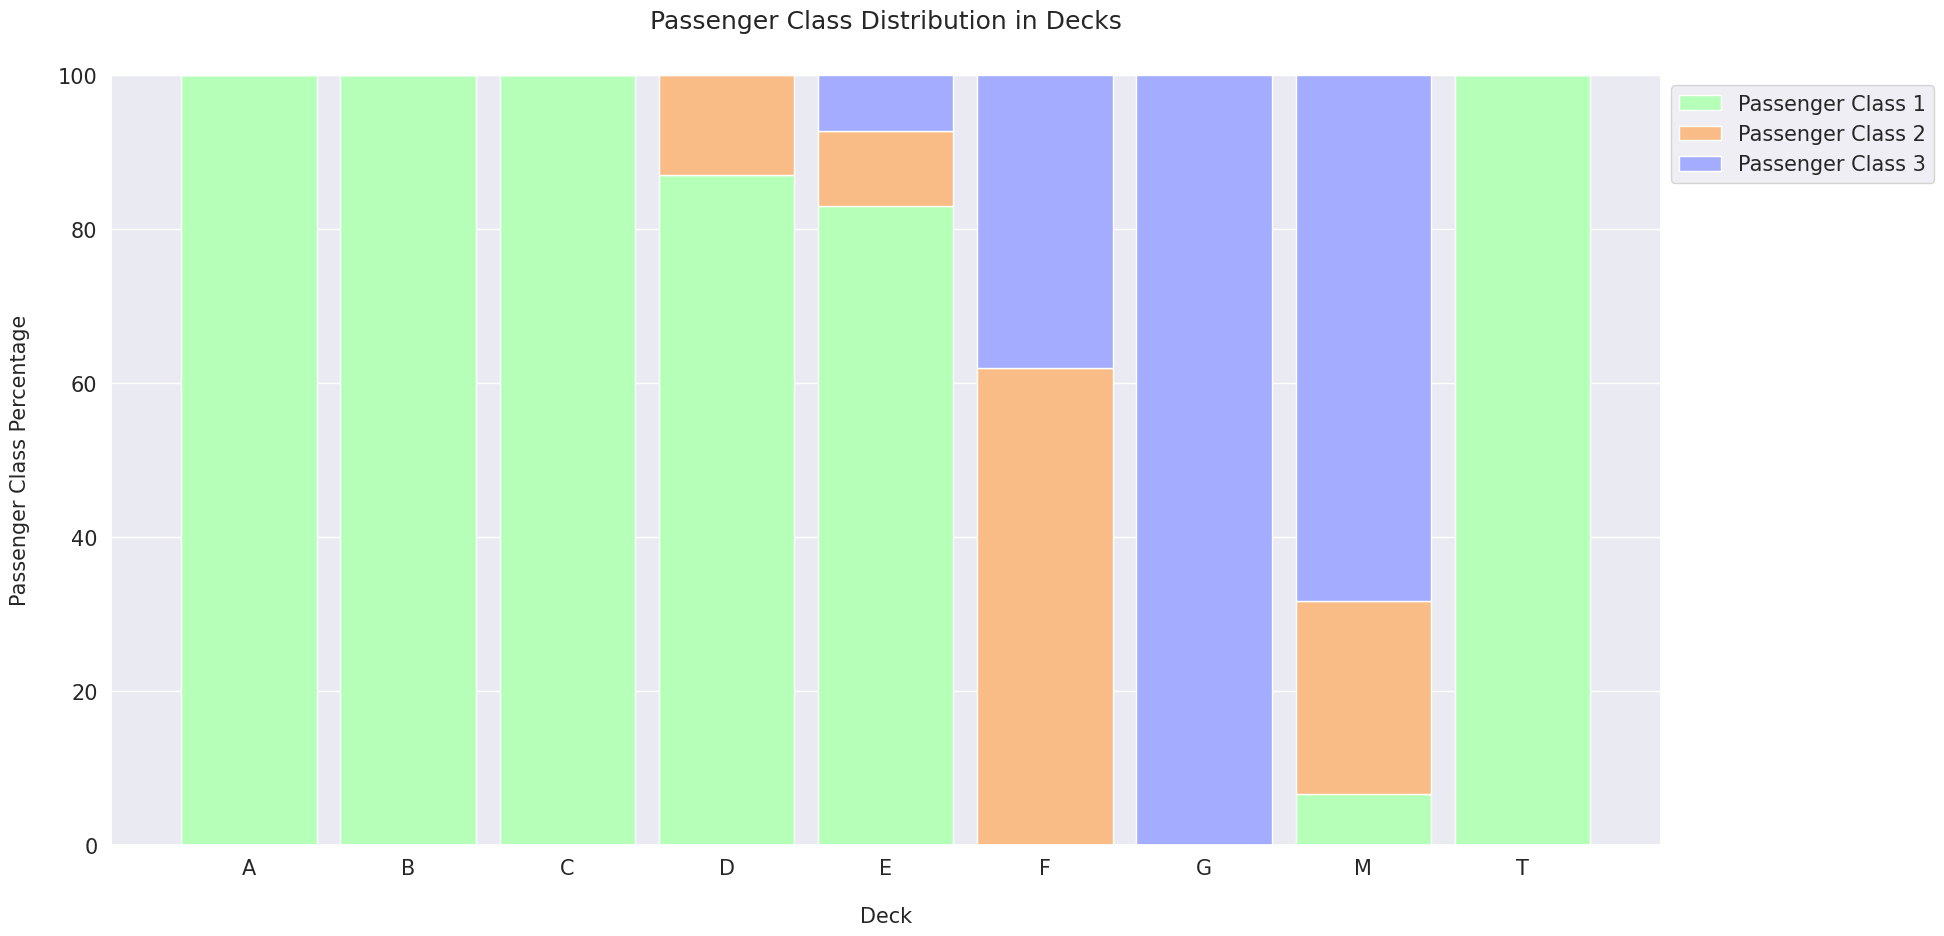

In [12]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

In [13]:
# Passenger in the T deck is changed to A
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

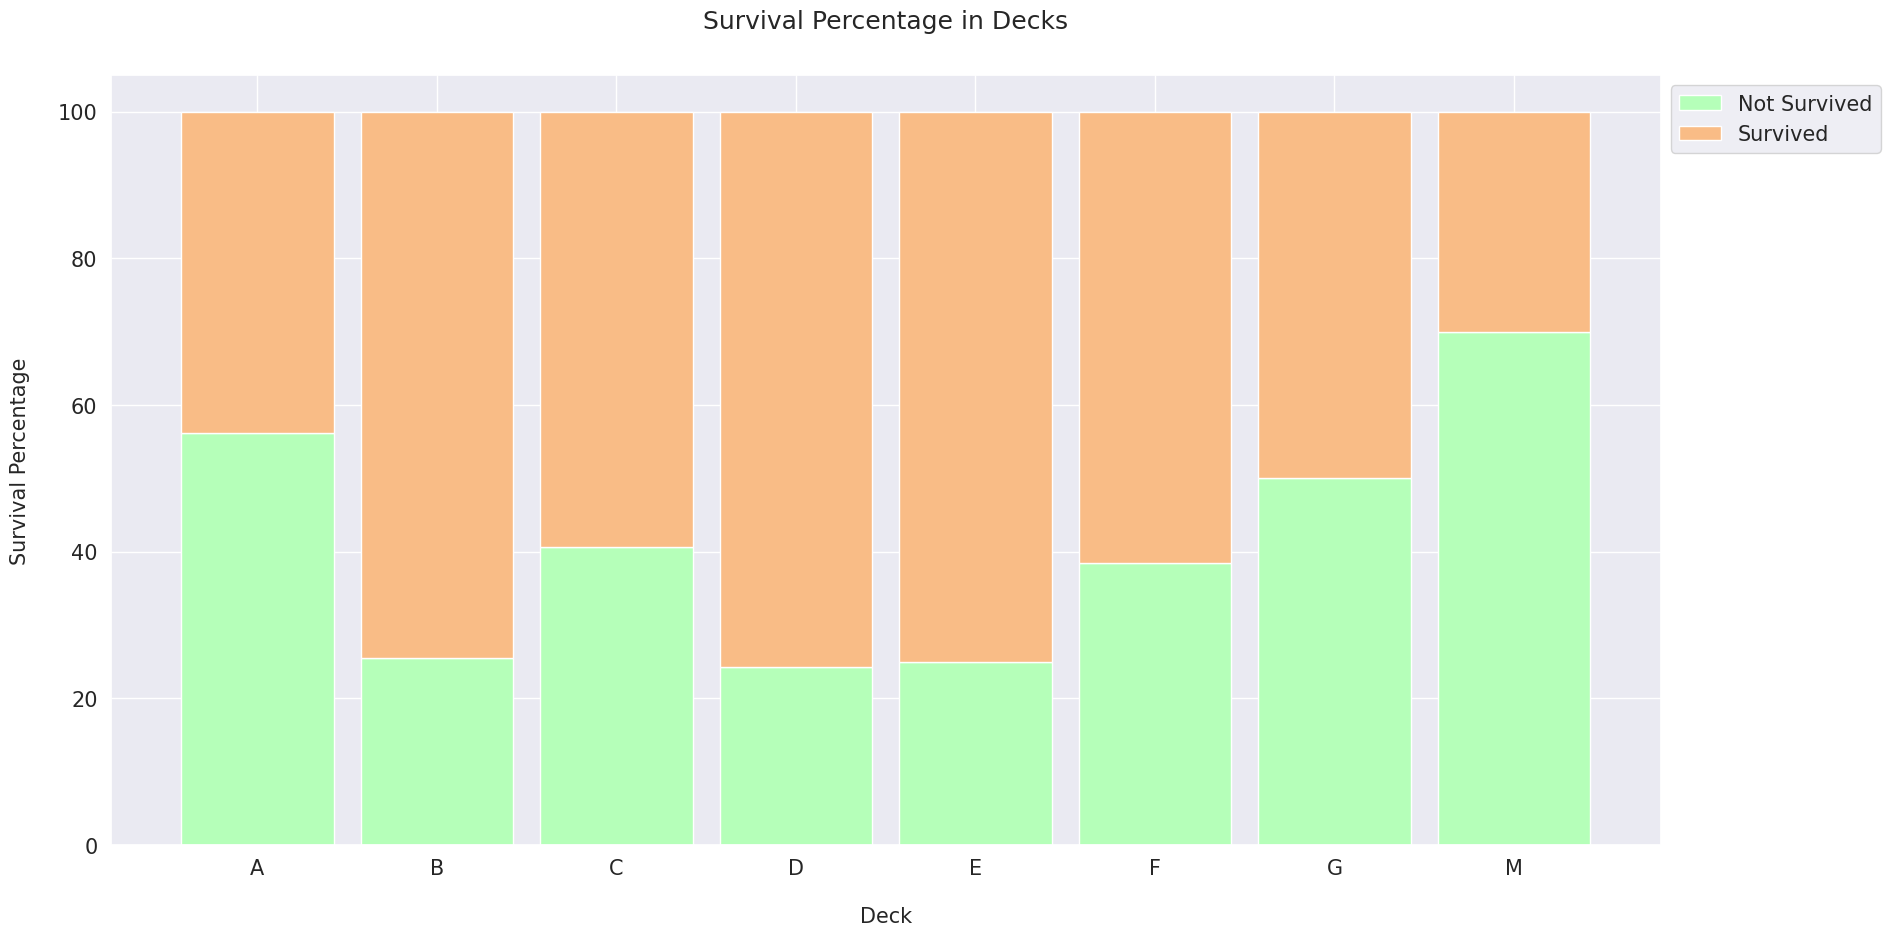

In [14]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

In [15]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

In [16]:
# Dropping the Cabin feature
df_all.drop(['Cabin'], inplace=True, axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

for df in dfs:
    display_missing(df)

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0


Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0




342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


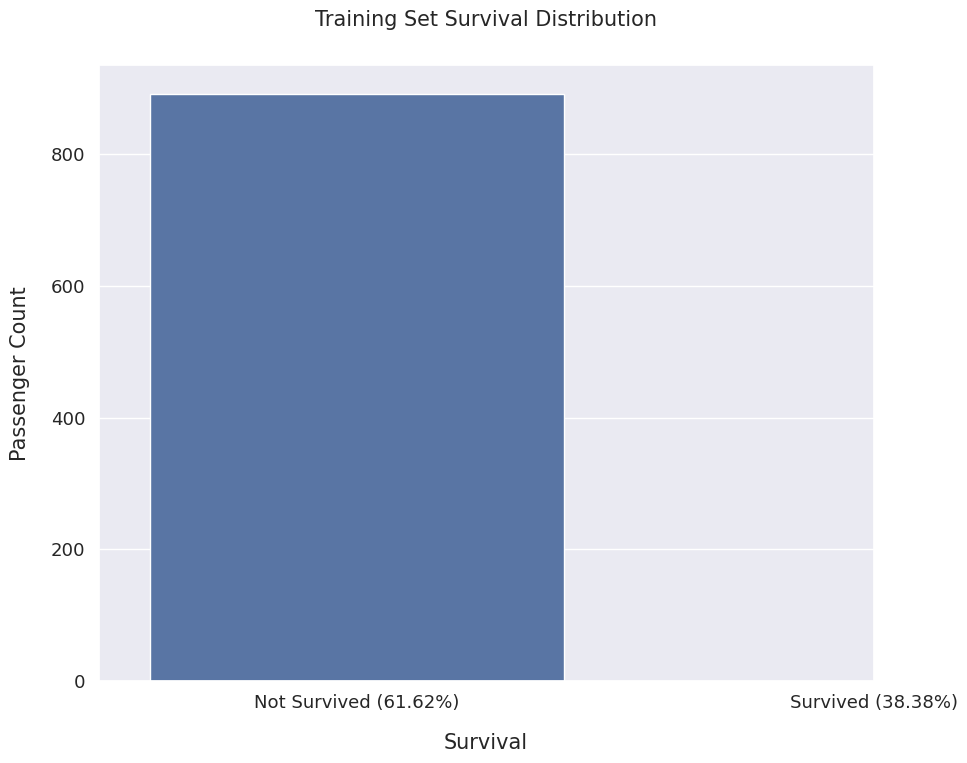

In [17]:
survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]
survived_per = survived / df_train.shape[0] * 100
not_survived_per = not_survived / df_train.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(survived, df_train.shape[0], survived_per))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'.format(not_survived, df_train.shape[0], not_survived_per))

plt.figure(figsize=(10, 8))
sns.countplot(df_train['Survived'])

plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived_per), 'Survived ({0:.2f}%)'.format(survived_per)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()